In [65]:
#!pip install pandas numpy matplotlib statsmodels gdown

In [67]:
#!pip install pmdarima darts

## Download Data

In [4]:
# https://drive.google.com/file/d/1k2qILdyzADkZBH78bYfiuLqy3sqVLFCB/view?usp=drive_link
#!gdown 1k2qILdyzADkZBH78bYfiuLqy3sqVLFCB

## Dataset

In this exercise, we're using ticket sales data collected between January 2015 and April 2017. Over time, as there's more demand for tickets, new venues have been added thus increasing total capacity.

The `sales_data.csv` file has four columns: `date`, `sold` (number of tickets), `capacity`, and `revenue` ($). We'll be focusing on the number of tickets sold (column `sold`) only.

Load the data into a Pandas dataframe and set the date as index.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sys.path.append('..')

# load the data
df = pd.read_csv(r'../data/raw/sales_data.csv', delimiter=',')

# Convert the 'date' column to datetime format (optional but recommended)
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

df

,sold,capacity,revenue
date,,,
2015-01-01,554,984,5037.0
2015-01-02,695,984,6293.0
2015-01-03,585,984,5265.0
2015-01-04,491,984,4419.0
2015-01-05,449,984,4041.0
...,...,...,...
2017-04-26,900,1640,11045.0
2017-04-27,1076,1804,13473.0
2017-04-28,1828,3034,24353.0


Then, plot the data. Do you see any distinguishable patterns? Does it seem to have a trend over time?

<Axes: xlabel='date'>

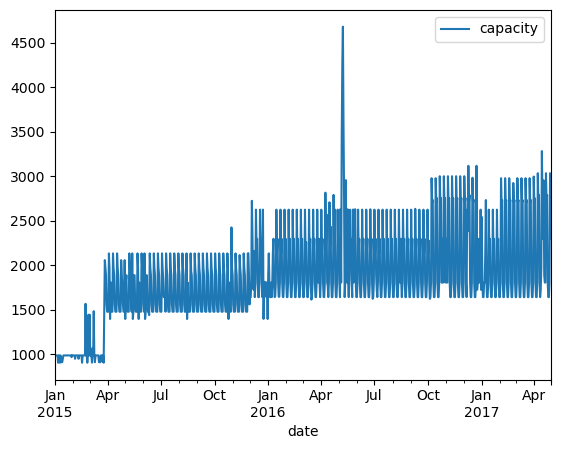

In [21]:
capacity = df[['capacity']]
capacity.plot()

<Axes: xlabel='date'>

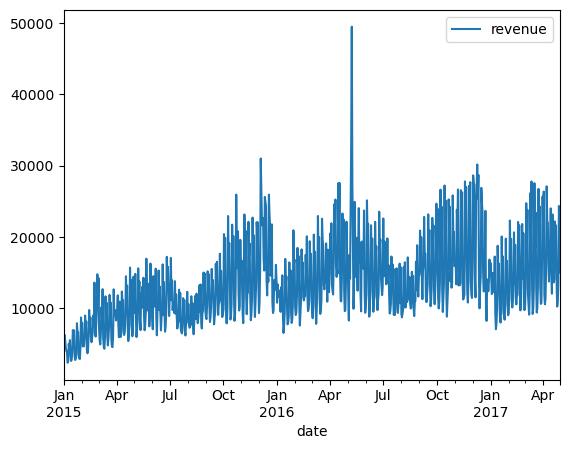

In [23]:
revenue = df[['revenue']]
revenue.plot()

<Axes: xlabel='date'>

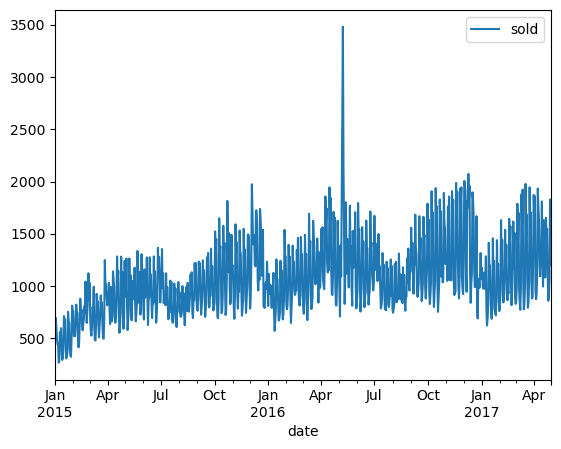

In [25]:
sales = df[['sold']]
sales.plot()

<Axes: xlabel='date'>

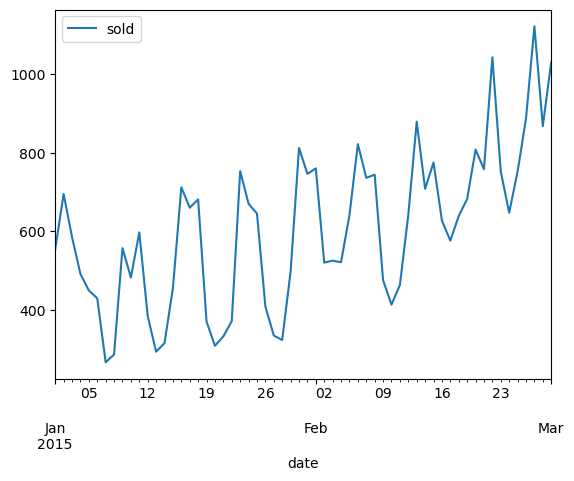

In [27]:
sales2 = df[['sold']].iloc[:60]
sales2.plot()

# Part #0

## Stationarity

In order to check if there's a trend or not, we need to check the series' stationarity. We'll use the Augmented Dick-Fuller's Test (the function is reproduced below for your convenience).

Hint: you can model a linear trend (if there's one) by adding `t` to the `regression` argument.

In [31]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries, regression='c'):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC", regression=regression)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [33]:
adf_test(df.sold, regression='c') #with ct we gonna fit a linear regression and then subtract it, then apply the test again

Results of Dickey-Fuller Test:
Test Statistic                  -3.131253
p-value                          0.024325
#Lags Used                      21.000000
Number of Observations Used    829.000000
Critical Value (1%)             -3.438263
Critical Value (5%)             -2.865033
Critical Value (10%)            -2.568630
dtype: float64


Is there a trend?

### no trend, as we reject the null hypothesis with a small p-value

## Seasonality

Now, we need to check if the series shows signs of seasonality. We may use the autocorrelation function (ACF) plot to investigate this.

Hint: recurring spikes as every `t` steps are a sign of a seasonality (`t` periods)

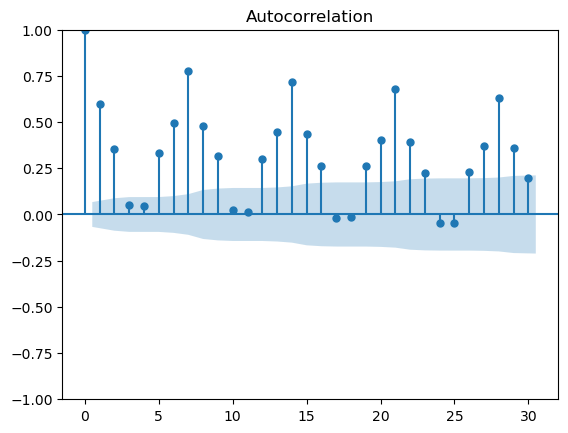

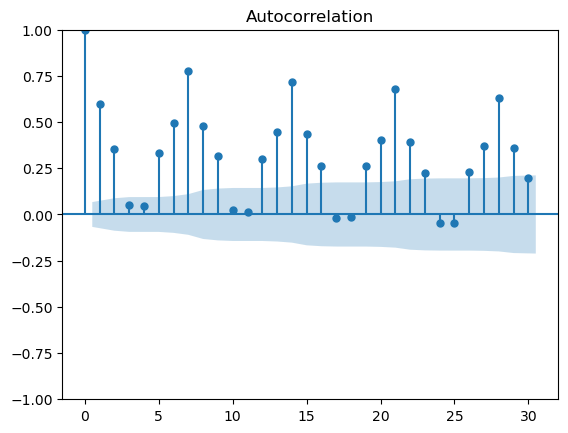

In [38]:
from statsmodels.graphics.tsaplots import plot_acf

# plot the ACF
plot_acf(df.sold)

Is there seasonality in the series?

### yes, a weekly seasonality!

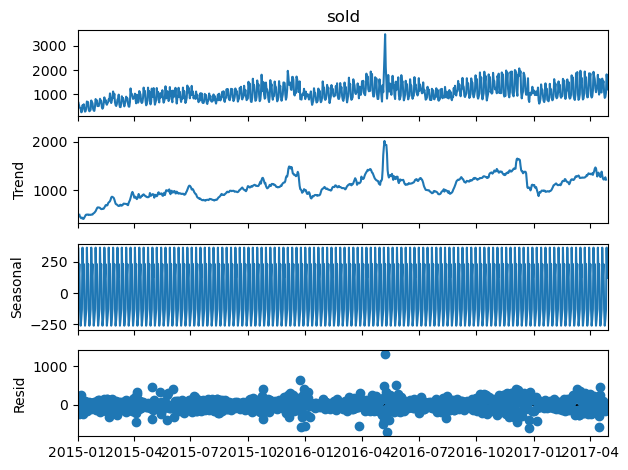

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming your 'sold' column contains the time series data
result = seasonal_decompose(df['sold'], model='additive', period=7)  # Set 'period' based on your expected seasonality (e.g., 12 for monthly data)

# Plot the decomposition
result.plot()
plt.show()

## ARIMA

Let's try an ARIMA model but, first, let's save the last 28 days as our test set.

In [44]:
#%pip install pmdarima

In [47]:
from pmdarima import model_selection

train, test = model_selection.train_test_split(sales, train_size=len(sales)-28)

The ADF test implemented in `pmdarima` should give us the same result as before and, on top of that, it tell us straight away if we should differentiate the series or not.

In [50]:
from pmdarima.arima import ADFTest

ADFTest().should_diff(train)

(0.01, False)

In order to steer the choice of the appropriate ARIMA model, we need to provide the function with the information about the need (or not) to differentiate the time series (arguments `d` and `D`, the latter for the seasonal component, if any) and if there's seasonality (`seasonal` may be true or false, and `m` specifies the number of periods in the seasonality, as you have determined above).

In [53]:
import pmdarima as pm

# choose your parameters here
d = 0
D = 0
seasonal = True
m = 7

# Fit a simple auto_arima model
arima = pm.auto_arima(train,
                      error_action='ignore', trace=True, suppress_warnings=True, maxiter=5,
                      d=d, D=D, seasonal=seasonal, m=m)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=15706.253, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=12031.986, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=11374.181, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=11534.052, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=13896.594, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=11666.611, Time=0.18 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=13778.808, Time=0.47 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=16844.766, Time=0.17 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=11384.029, Time=0.18 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=14350.617, Time=0.30 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=11982.759, Time=0.24 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=11623.518, Time=0.67 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=12205.040, Time=0.23 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=12098.087, Time=0.25 sec
 ARIMA(2,0,1)(1,0,0

Now, let's plot the model's fitted values.

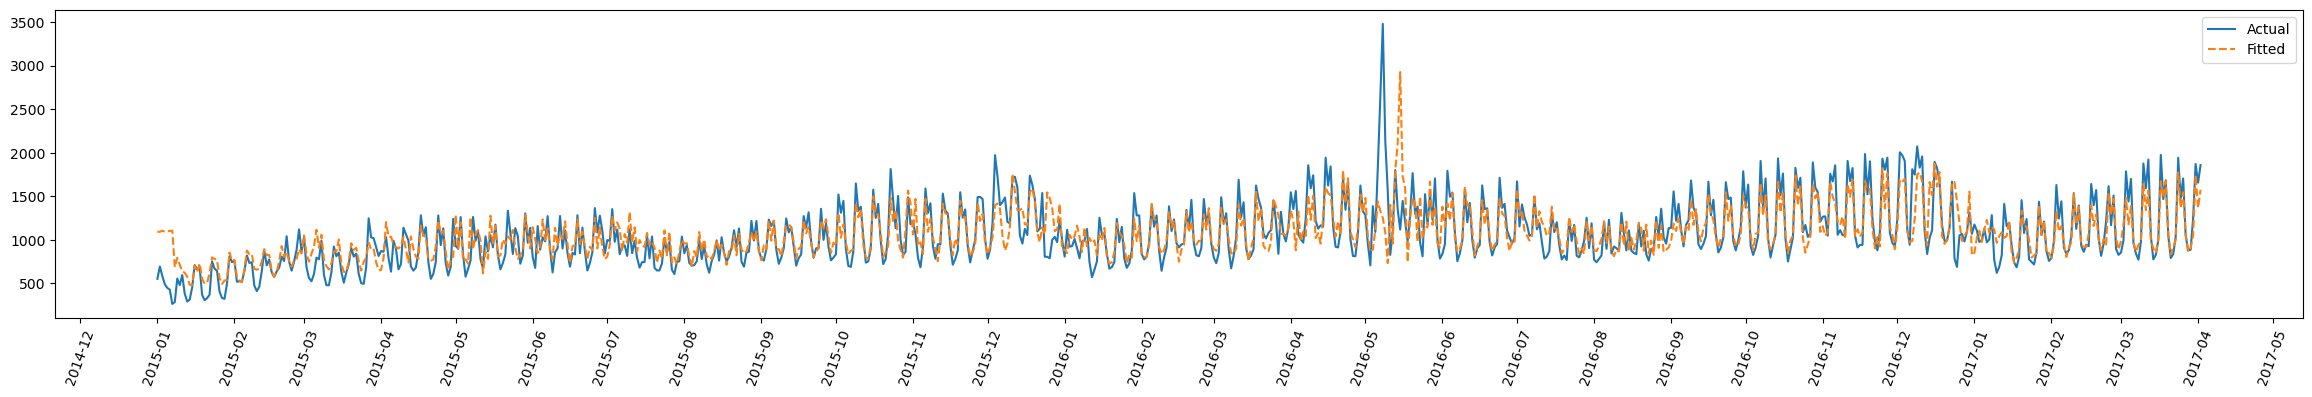

In [55]:
#AR 2 lags, and one lag with a seasonality of 7


fig, ax = plt.subplots(1, 1, figsize=(29, 4))
ax.plot(train.index, train, label='Actual')
ax.plot(train.index, arima.fittedvalues(), label='Fitted', linestyle='--')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=70)
plt.legend()

Does it look good? Do you see anything peculiar?

Then, let's try a scatter plot to compare actual and forecast values.

Text(0, 0.5, 'Forecast')

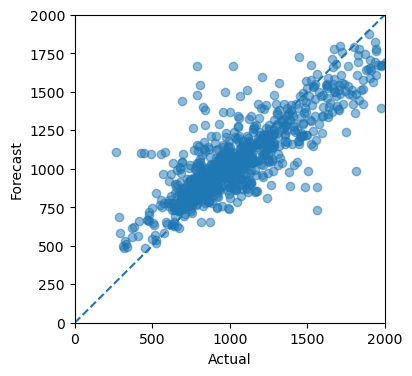

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(train, arima.fittedvalues(), alpha=0.5)
ax.plot([0, 2000], [0, 2000], linestyle='--')
ax.set_xlim([0, 2000])
ax.set_xlabel('Actual')
ax.set_ylim([0, 2000])
ax.set_ylabel('Forecast')

Does it match your expectations, after you've seen the previous plot?

Next, let's get some actual metrics for our model, namely, MAPE and sMAPE.

In [61]:
def mape(y_true, y_pred):
    actual = y_true.copy()
    forecast = y_pred.copy()
    if isinstance(actual, (pd.Series, pd.DataFrame)):
        actual = actual.values
    if isinstance(forecast, (pd.Series, pd.DataFrame)):
        forecast = forecast.values
    if isinstance(actual, np.ndarray):
        actual = actual.squeeze()
    if isinstance(forecast, np.ndarray):
        forecast = forecast.squeeze()

    # Ensure the arrays have the same length
    assert len(actual) == len(forecast), "Length of actual and forecast arrays should be the same"

    # Avoid division by zero by replacing zeros in the 'actual' array with a small number
    actual = np.where(actual == 0, 1e-10, actual)

    # Calculate MAPE for each data point
    mape_values = np.abs((actual - forecast) / actual)

    # Calculate the mean MAPE value
    mean_mape = np.mean(mape_values) * 100  # Multiply by 100 to get percentage

    return mean_mape

def smape(y_true, y_pred):
    actual = y_true.copy()
    forecast = y_pred.copy()
    if isinstance(actual, (pd.Series, pd.DataFrame)):
        actual = actual.values
    if isinstance(forecast, (pd.Series, pd.DataFrame)):
        forecast = forecast.values
    if isinstance(actual, np.ndarray):
        actual = actual.squeeze()
    if isinstance(forecast, np.ndarray):
        forecast = forecast.squeeze()

    # Ensure the arrays have the same length
    assert len(actual) == len(forecast), "Length of actual and forecast arrays should be the same"

    # Calculate SMAPE for each data point
    smape_values = 2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast))

    # Calculate the mean SMAPE value
    mean_smape = np.mean(smape_values) * 100  # Multiply by 100 to get percentage

    return mean_smape

In [63]:
smape(train, arima.fittedvalues())


14.057772634354132

Now, let's make a forecast for the 28 days in the future (our test set).

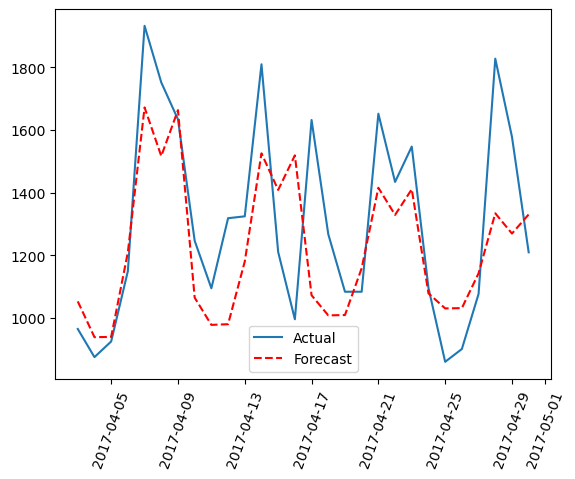

In [66]:
x = np.arange(test.shape[0])
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima.predict(n_periods=len(x)), label='Forecast', linestyle='--', c='r')
plt.xticks(rotation=70)
plt.legend()

## The forecast is only 1 week into the future well done. After 1 week, it takes into account the previous forecast and is accumulating errors.

Is it good? What happens over time? Can you guess why?

Text(0, 0.5, 'Forecast')

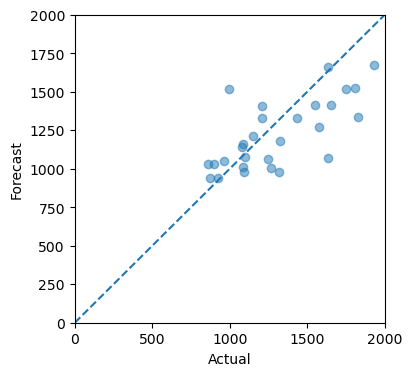

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(test, arima.predict(n_periods=len(x)), alpha=0.5)
ax.plot([0, 2000], [0, 2000], linestyle='--')
ax.set_xlim([0, 2000])
ax.set_xlabel('Actual')
ax.set_ylim([0, 2000])
ax.set_ylabel('Forecast')

# Part #1

## Simple Exponential Smoothing (SES)

Next, let's try a basic SES model but, instead of trying to guess the smoothing and initial levels, we'll let the model estimate the initial level (`initialization_method`) and optimize the smoothing level (`optimized`).

In [74]:
from statsmodels.tsa.api import SimpleExpSmoothing

# create the SES model
ses = SimpleExpSmoothing(train)
ses = ses.fit()
ses.params

C:\Users\Administrator\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 0.09709302325581395,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 554.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Which smoothing level did we get? Will it track the actual data closely or loosely? Why?

After you answered these questions, plot the fitted values to find out.

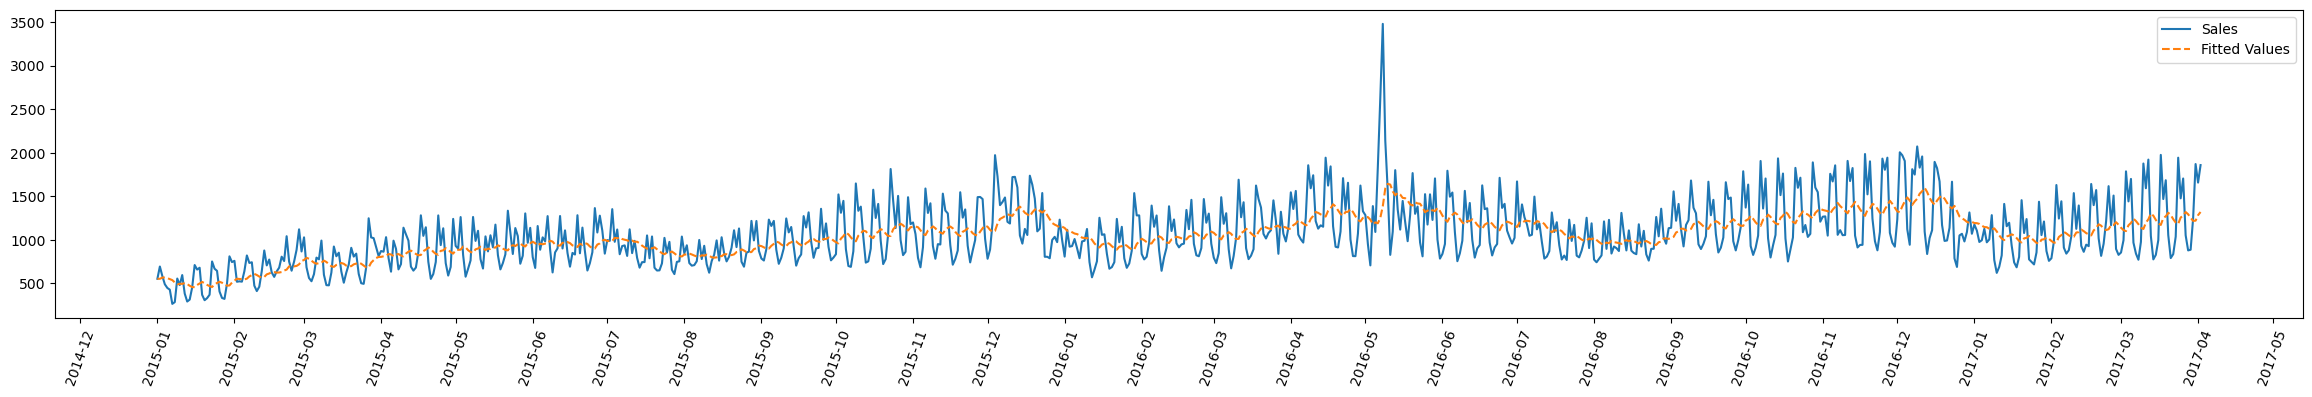

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(29, 4))
ax.plot(train.index, train, label='Sales')
ax.plot(train.index, ses.fittedvalues, linestyle='--', label='Fitted Values')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=70)
ax.legend()

Did it match your expectations?

If we try the scatter plot once again, do you think it will be better or worse than the previous one? Why?

Text(0, 0.5, 'Forecast')

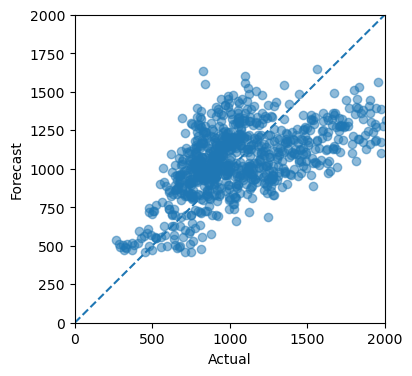

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(train, ses.fittedvalues, alpha=0.5)
ax.plot([0, 2000], [0, 2000], linestyle='--')
ax.set_xlim([0, 2000])
ax.set_xlabel('Actual')
ax.set_ylim([0, 2000])
ax.set_ylabel('Forecast')

Did you get it right?

Let's compute MAPE and sMAPE once again:

In [82]:
# compute MAPE ans sMAPE
# Given dataset

# Compute MAPE and SMAPE
mape_value = mape(train, ses.fittedvalues)
smape_value = smape(train, ses.fittedvalues)

# Output the computed values
print(f"MAPE: {mape_value}")
print(f"SMAPE: {smape_value}")

MAPE: 23.19982180167445
SMAPE: 22.28757117800343


Now, consider the 28-day forecast, how would it look like for a SES model? Once you answered it, run the plot below.

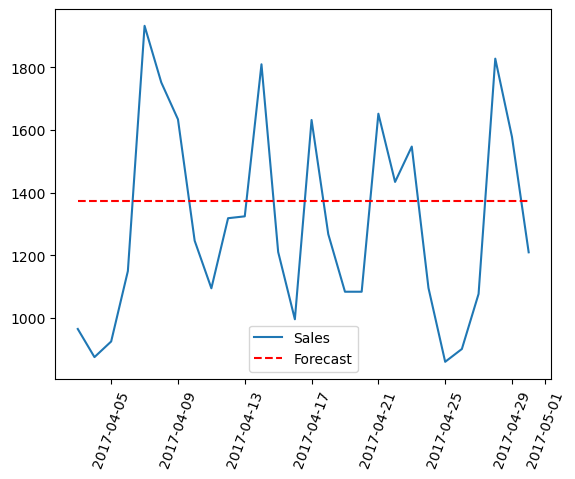

In [85]:
plt.plot(test.index, test, label='Sales')
plt.plot(test.index, ses.forecast(28), linestyle='--', c='r', label='Forecast')
plt.xticks(rotation=70)
plt.legend()

Did it match your expecations?

### Probabilistic Forecasting

Exponential smoothing models are interesting because they allow us to reframe them as probabilistic (ETS) models. Let's run the very same model as above probabilistic-style!

In [89]:
train

,sold
date,
2015-01-01,554
2015-01-02,695
2015-01-03,585
2015-01-04,491
2015-01-05,449
...,...
2017-03-29,888
2017-03-30,1246
2017-03-31,1872


In [91]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# create the ETS model here
model = ETSModel(train.sold)
# fit the model
fit = model.fit()
# Display the model summary
print(fit.summary())

                                 ETS Results                                  
Dep. Variable:                   sold   No. Observations:                  823
Model:                       ETS(ANN)   Log Likelihood               -5862.887
Date:                Tue, 01 Oct 2024   AIC                          11731.775
Time:                        16:42:39   BIC                          11745.913
Sample:                    01-01-2015   HQIC                         11737.199
                         - 04-02-2017   Scale                        90194.401
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.0959      0.015      6.236      0.000       0.066       0.126
initial_level     606.2000    129.152      4.694      0.000     353.066     859.334
Ljung-Box (Q):                  

C:\Users\Administrator\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [93]:
# model = ETSModel(train['sold'],
#                      error='add',        # Error term: 'add' (additive) or 'mul' (multiplicative)
#                      trend=None,        # Trend term: 'add' (additive) or 'mul' (multiplicative) or None
#                      seasonal=None,     # Seasonal term: 'add' (additive) or 'mul' (multiplicative) or None
#                      seasonal_periods=7 # Set the seasonal periods (e.g., 12 for monthly data)
#                     )
# fit = model.fit(maxiter=1000)
# fit.fittedvalues

Now, forecast the values for the next 28 days, from 2017-04-03 to 2017-04-30 using the `get_prediction()` method:

In [96]:
start_date = '2017-04-03'
end_date = '2017-04-30'

# Get prediction for the specified date range
pred = fit.get_prediction(start=start_date, end=end_date)

# Extract the forecasted values
forecast_values = pred.predicted_mean

What do you expect the following cell to produce?

In [99]:
pred.predicted_mean

2017-04-03    1371.948687
2017-04-04    1371.948687
2017-04-05    1371.948687
2017-04-06    1371.948687
2017-04-07    1371.948687
2017-04-08    1371.948687
2017-04-09    1371.948687
2017-04-10    1371.948687
2017-04-11    1371.948687
2017-04-12    1371.948687
2017-04-13    1371.948687
2017-04-14    1371.948687
2017-04-15    1371.948687
2017-04-16    1371.948687
2017-04-17    1371.948687
2017-04-18    1371.948687
2017-04-19    1371.948687
2017-04-20    1371.948687
2017-04-21    1371.948687
2017-04-22    1371.948687
2017-04-23    1371.948687
2017-04-24    1371.948687
2017-04-25    1371.948687
2017-04-26    1371.948687
2017-04-27    1371.948687
2017-04-28    1371.948687
2017-04-29    1371.948687
2017-04-30    1371.948687
Freq: D, dtype: float64

Let's make it more interesting now and produce some confidence intervals for the prediction (choose an `alpha` level) using the `summary_frame()` method (from the predictions object)

In [6]:
# choose your alpha
alpha = 0.05 # for the confidence interval

# call the summary_frame method
df = pred.summary_frame()
df

NameError: name 'pred' is not defined

Now, use the `simulate()` method (from the fitted model result) to generate multiple forecast scenarios (`repetitions` arg) for a given time period `nsimulations` arg):

In [9]:
nsimulations = 28
repetitions = 100

simulated = fit.simulate(anchor="end", nsimulations=nsimulations, repetitions=repetitions)
simulated

NameError: name 'fit' is not defined

The plot below puts everything together, simulations and confidence intervals:

In [12]:
for i in range(simulated.shape[1]):
    simulated.iloc[:, i].plot(label="_", color="gray", alpha=0.1)

df["mean"].plot(label="mean prediction", linestyle='--', c='r')
df["pi_lower"].plot(linestyle="--", c='b', label="95% interval")
df["pi_upper"].plot(linestyle="--", c='b', label="_")
plt.plot(test.index, test, label='Sales')
plt.legend()

NameError: name 'simulated' is not defined

## Holt-Winters

It is time to use a better model like Triple Exponential Smoothing (Holt-Winters). In this model, we can specify both trend and seasonal components:
- seasonality through `seasonal` (`add`, `mul`, or `None`) and `seasonal_periods` arguments
- trend through `trend` (`add`, `mul`, or `None`) argument
As before, we can have the model estimate the initial level and optimize the smoothing level.

In [111]:
from statsmodels.tsa.api import ExponentialSmoothing

# choose the number of periods
seasonal_periods = 7

# create an instance of exponential smoothing and call its fit() method in one go
holt_winters = ExponentialSmoothing(train.sold, 
                                    trend='add', 
                                    seasonal='add', 
                                    initialization_method="estimated",
                                    seasonal_periods=seasonal_periods, 
                                   ).fit(optimized=True)

holt_winters.summary()

C:\Users\Administrator\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Dep. Variable:,sold,No. Observations:,823
Model:,ExponentialSmoothing,SSE,26622462.607
Optimized:,True,AIC,8568.287
Trend:,Additive,BIC,8620.129
Seasonal:,Additive,AICC,8568.737
Seasonal Periods:,7,Date:,"Tue, 01 Oct 2024"
Box-Cox:,False,Time:,16:42:47
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3135058,alpha,True
smoothing_trend,0.0001245,beta,True


Let's visualize the actual and fitted values, both as line and scatter plots:

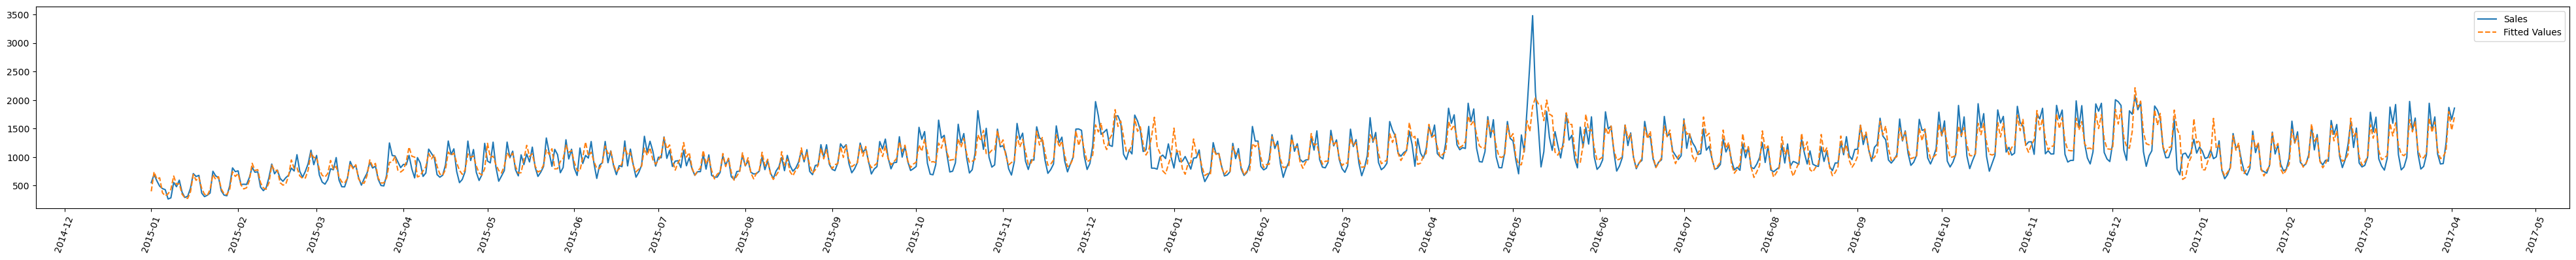

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(50, 4))
ax.plot(train.index, train, label='Sales')
ax.plot(train.index, holt_winters.fittedvalues, linestyle='--', label='Fitted Values')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=70)
ax.legend()

Text(0, 0.5, 'Forecast')

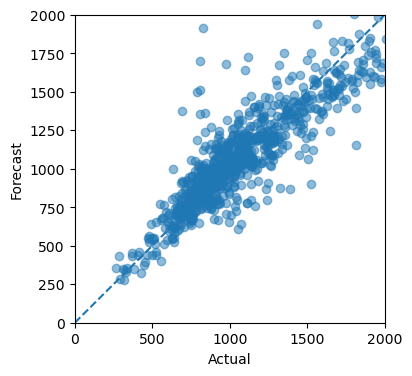

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(train, holt_winters.fittedvalues, alpha=0.5)
ax.plot([0, 2000], [0, 2000], linestyle='--')
ax.set_xlim([0, 2000])
ax.set_xlabel('Actual')
ax.set_ylim([0, 2000])
ax.set_ylabel('Forecast')

How does this model compare to the first ARIMA model we fitted?

Compute both MAPE and sMAPE metrics to get a more definitive answer.

In [119]:
# compute MAPE and sMAPE
...

Now, make a forecast for 28 days ahead using the `forecast()` method and compare to the actual data:

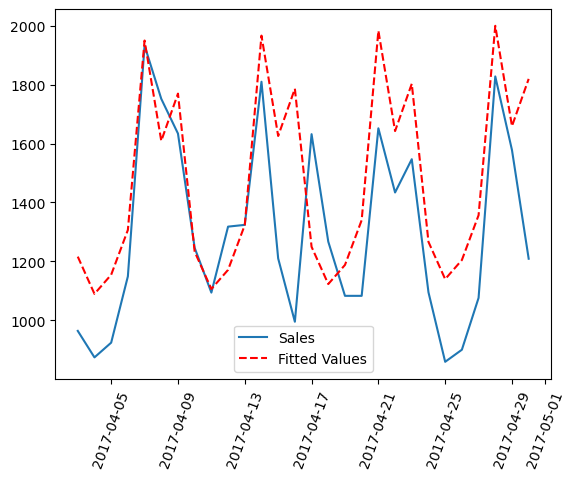

In [122]:
# make the forecast
fc_values = holt_winters.forecast(28)

plt.plot(test.index, test, label='Sales')
plt.plot(test.index, fc_values, linestyle='--', c='r', label='Fitted Values')
plt.xticks(rotation=70)
plt.legend()

How is this forecast different than the previous ones (e.g. patterns, evolution over time)?

Let's make it more interesting by fitting a probabilistic model. We're still using the `ETSModel` class, but we can add the same arguments we've already used to fit the Holt-Winters models above.

In [125]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

seasonal_periods = 7

model = ETSModel(
    train.squeeze(),
    seasonal_periods=seasonal_periods,
    trend="add",
    seasonal="add",
    initialization_method="estimated"
)
fit = model.fit()

C:\Users\Administrator\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Make predictions using the `get_prediction()` method for the period starting on 2017-04-03 and ending on 2017-04-30 and plot the predicted mean against actual sales.

In [128]:
pred = fit.get_prediction(start="2017-04-03", end="2017-04-30")

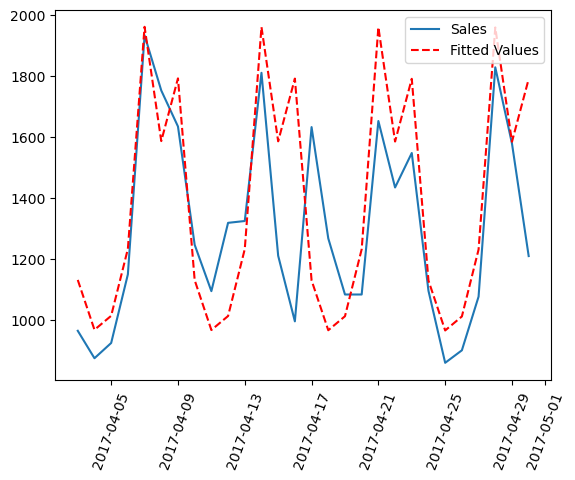

In [130]:
fit_vals = pred.predicted_mean

plt.plot(test.index, test, label='Sales')
plt.plot(test.index, fit_vals, linestyle='--', c='r', label='Fitted Values')
plt.xticks(rotation=70)
plt.legend()

### Probabilistic Forecasting

Now, compute confidence intervals using the `summary_frame()` method once again. Next, simulate forecast scenarios for 28 days ahead using `simulate()` method once again.

In [133]:
df = pred.summary_frame(alpha=0.05)
simulated = fit.simulate(anchor="end", nsimulations=28, repetitions=100)

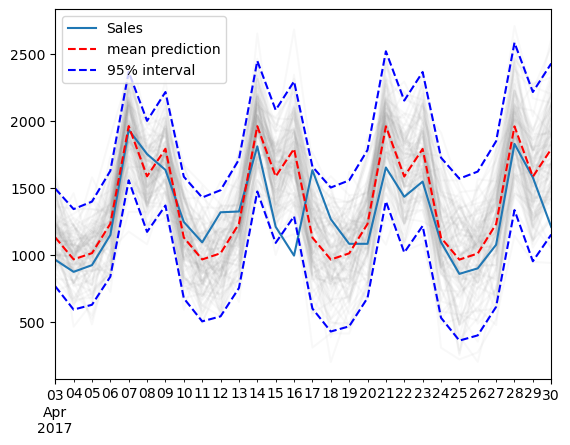

In [135]:
for i in range(simulated.shape[1]):
    simulated.iloc[:, i].plot(label="_", color="gray", alpha=0.05)

plt.plot(df.index, test, label='Sales')
df["mean"].plot(label="mean prediction", linestyle='--', c='r')
df["pi_lower"].plot(linestyle="--", color="b", label="95% interval")
df["pi_upper"].plot(linestyle="--", color="b", label="_")
plt.legend()

# Part #2

## Seasonal Decomposition

Decompose the training set into its trend, seasonal, and residual components using statsmodels' `seasonal_decompose`:

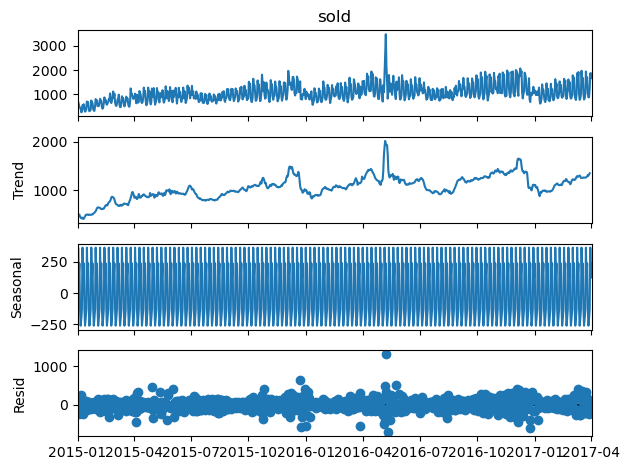

In [139]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Decompose the time series
result = seasonal_decompose(train['sold'], model='additive', period=7)


# decompose the time series
result.plot();

In [141]:
df2 = pd.concat([result.trend, result.seasonal, result.resid], axis=1).tail(20)
df2

# residuals are org-seasonal-trend

,trend,seasonal,resid
date,,,
2017-03-14,1306.285714,-259.398460,-269.887254
2017-03-15,1288.571429,-206.299559,-253.271870
2017-03-16,1254.714286,-130.253161,-126.461125
2017-03-17,1256.285714,361.387075,359.327210
2017-03-18,1258.428571,120.624760,90.946668
2017-03-19,1259.571429,236.011796,190.416775
2017-03-20,1265.285714,-122.072453,-86.213262
2017-03-21,1260.714286,-259.398460,-209.315826
2017-03-22,1261.857143,-206.299559,-218.557584


What's happening at the end of the training period? Why?

Compute the strength of both trend and seasonal components. Did you expect the results?

In [144]:
# Trend
strength_trend = max(0, 1-df2['resid'].var()/(df2['resid']+df2['trend']).var())

# Season
strength_season = max(0, 1-df2['resid'].var()/(df2['resid']+df2['seasonal']).var())

strength_trend, strength_season

(0, 0.7681561501336347)

## STL Decomposition

Now, use STL decomposition instead. Remember that `period` represnts the seasonality period while `seasonal` (as confusing as it may be) represents **how many seasons** should be used to smoothen the seasonality using LOESS.

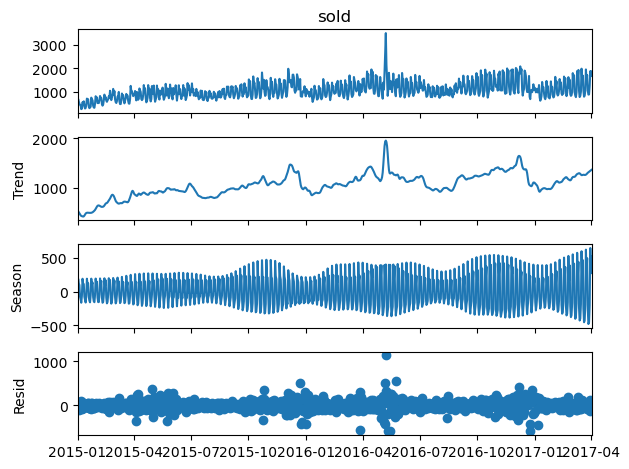

In [149]:
from statsmodels.tsa.seasonal import STL

# Perform STL decomposition
stl = STL(train['sold'], seasonal=15, period=7)  # seasonal=13 seasonal could be 52 that would be a whole year smoothing
res = stl.fit()
# fit the decomposition
res.plot();

Look at the seasonal component of the plot above. How is it different than traditional seasonal decomposition? Why is that?

In [151]:
df3 = pd.concat([res.trend, res.seasonal, res.resid], axis=1).tail(28)
df3

,trend,season,resid
date,,,
2017-03-06,1224.314633,-229.669235,-25.645399
2017-03-07,1234.111701,-403.653453,13.541752
2017-03-08,1250.871977,-375.995077,-101.876900
2017-03-09,1267.532405,-177.574348,-111.958057
2017-03-10,1279.180456,576.842722,21.976822
2017-03-11,1286.411549,203.983203,103.605248
2017-03-12,1291.266099,442.618497,189.115404
2017-03-13,1296.462277,-240.664792,-9.797485
2017-03-14,1294.081203,-429.122449,-87.958755


Compute the strength of both trend and seasonal components:

In [153]:
# Trend
strength_trend = max(0, 1-df3['resid'].var()/(df3['resid']+df3['trend']).var())

# Season
strength_season = max(0, 1-df3['resid'].var()/(df3['resid']+df3['season']).var())

strength_trend, strength_season

(0.2309251631003445, 0.9693783070767221)

Now, use `STLForecast` to model and forecast seasonality while using an exponential smoothing model to forecast both level and trend (if any):

In [155]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.statespace import exponential_smoothing

index = pd.date_range(train.index[0], periods=len(train), freq='D')
train.index = index

ES = exponential_smoothing.ExponentialSmoothing
config = {"trend": False, "initialization_method": "estimated"}

# choose the period and number of seasons
period = 7
s_window = 15

stlf = STLForecast(train, ES, model_kwargs=config, period=period, seasonal=s_window)
resf = stlf.fit()
forecasts = resf.forecast(28)

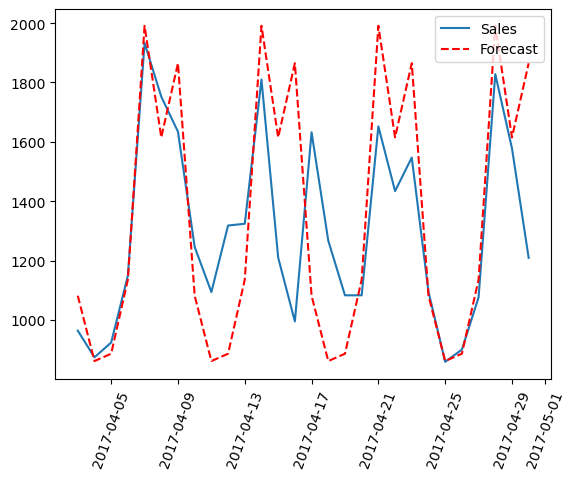

In [157]:
plt.plot(test.index, test, label='Sales')
plt.plot(test.index, forecasts, label='Forecast', c='r', linestyle='--')
plt.xticks(rotation=70)
plt.legend()

How is this forecast different from that produced by the Holt-Winters method? Why?

# Part #3

## Feature Engineering

It is time to do some feature engineering. We'll create deterministic features out of the date components.

### Date Components

The index is being recreated as a proper date index to allow you to easily extract date components such as `day`, `month`, `weekday`, `weekofyear`, etc.

Given the seasonality of our time series, which components would you choose? For each chosen component, create a corresponding column in the `train` dataframe.

Hint: `weekofyear` was deprecated in favor of `isocalendar().week.astype(int)`

In [8]:
import pandas as pd

In [159]:
index = pd.date_range('2015-01-01', periods=823, freq='D')
train.index = index

train['t'] = pd.RangeIndex(len(train))

train

# create one or more columns in the DF using properties of the index
#newcol1 = ...
train['dayoftheweek'] = train.index.dayofweek
train['day'] = train.index.day
train['month'] = train.index.month
train['weekoftheyear'] = train.index.isocalendar().week.astype(int)
train

,sold,t,dayoftheweek,day,month,weekoftheyear
2015-01-01,554,0,3,1,1,1
2015-01-02,695,1,4,2,1,1
2015-01-03,585,2,5,3,1,1
2015-01-04,491,3,6,4,1,1
2015-01-05,449,4,0,5,1,2
...,...,...,...,...,...,...
2017-03-29,888,818,2,29,3,13
2017-03-30,1246,819,3,30,3,13
2017-03-31,1872,820,4,31,3,13
2017-04-01,1659,821,5,1,4,13


Now, use an R-style formula to describe how sold tickets (`sold`) can be expressed in terms of the chosen components. Remember that categorical features must be wrapped with a `C()` function in the formula.

In [264]:
import statsmodels.formula.api as smf

# https://www.statsmodels.org/stable/example_formulas.html
# write your formula here
formula = 'sold ~ t + C(weekoftheyear) + C(dayoftheweek) + C(month)'

mod_dummy = smf.ols(formula, data=train).fit()
mod_dummy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   sold   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     31.41
Date:                Tue, 01 Oct 2024   Prob (F-statistic):          1.60e-178
Time:                        17:05:37   Log-Likelihood:                -5451.5
No. Observations:                 823   AIC:                         1.104e+04
Df Residuals:                     752   BIC:                         1.138e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                478.8311     49.654      9.643      0.000     381.355     576.307
C(weekoftheyear)[T.2]    -94.7863     61.251     -1.547      0.122    -215.030      25.458
C(weekoftheyear)[T.3]    -56.1961     61.246     -0.918      0.359    -176.430      64.038
C(weekoftheyear)[T.4]    -28.7487     61.242     -0.469      0.639    -148.974      91.477
C(weekoftheyear)[T.5]    -65.4777     79.937     -0.819      0.413    -222.404      91.448
C(weekoftheyear)[T.6]   -112.3659    103.121     -1.090      0.276    -314.805      90.073
C(weekoftheyear)[T.7]    -62.6329    103.113     -0.607      0.544    -265.056     139.791
C(weekoftheyear)[T.8]    -40.9951    103.105     -0.398      0.691    -243.404     161.414
C(weekoftheyear)[T.9]     10.2118    110.916      0.092      0.927    -207.530     227.953
C(weekoftheyear)[T.10]     3.7525    128.080      0.029      0.977    -247.685     255.190
C(weekoftheyear)[T.11]   -14.0382    128.070     -0.110      0.913    -265.456     237.379
C(weekoftheyear)[T.12]    -5.8290    128.060     -0.046      0.964    -257.227     245.569
C(weekoftheyear)[T.13]    79.3366    127.904      0.620      0.535    -171.754     330.427
C(weekoftheyear)[T.14]    97.5146    143.265      0.681      0.496    -183.733     378.762
C(weekoftheyear)[T.15]   161.2548    148.117      1.089      0.277    -129.517     452.027
C(weekoftheyear)[T.16]    57.3926    148.101      0.388      0.698    -233.348     348.133
C(weekoftheyear)[T.17]   -46.3113    147.383     -0.314      0.753    -335.643     243.020
C(weekoftheyear)[T.18]   151.0367    154.580      0.977      0.329    -152.423     454.497
C(weekoftheyear)[T.19]   -74.2638    164.908     -0.450      0.653    -397.999     249.471
C(weekoftheyear)[T.20]   -93.4832    164.895     -0.567      0.571    -417.191     230.225
C(weekoftheyear)[T.21]  -142.7739    164.881     -0.866      0.387    -466.456     180.908
C(weekoftheyear)[T.22]  -131.6036    162.197     -0.811      0.417    -450.016     186.809
C(weekoftheyear)[T.23]  -207.9501    176.909     -1.175      0.240    -555.245     139.345
C(weekoftheyear)[T.24]  -222.8123    176.898     -1.260      0.208    -570.084     124.460
C(weekoftheyear)[T.25]  -219.9602    176.886     -1.244      0.214    -567.209     127.289
C(weekoftheyear)[T.26]  -160.9783    173.979     -0.925      0.355    -502.521     180.564
C(weekoftheyear)[T.27]   -51.8082    178.204     -0.291      0.771    -401.644     298.028
C(weekoftheyear)[T.28]  -197.9649    181.684     -1.090      0.276    -554.632     158.702
C(weekoftheyear)[T.29]  -272.9699    181.673     -1.503      0.133    -629.617      83.677
C(weekoftheyear)[T.30]  -287.6893    181.663     -1.584      0.114    -644.316      68.937
C(weekoftheyear)[T.31]  -216.6160    175.281     -1.236      0.217    -560.714  

Use the model to make predictions using the dummy variables you created:

In [267]:
# create a list of the column names you used in the formula
#formula = 'sold ~ t + weekoftheyear + dayoftheweek + C(month)'

columns = ['dayoftheweek', 't', 'month', 'weekoftheyear']
features = train[columns]

# make predictionspredictions = mod_dummy.predict(new_data)
pred = mod_dummy.predict(train)
pred

2015-01-01     468.124222
2015-01-02     961.363501
2015-01-03     722.762609
2015-01-04     840.949350
2015-01-05     386.700798
                 ...     
2017-03-29    1158.450153
2017-03-30    1234.401573
2017-03-31    1727.640852
2017-04-01    1578.823236
2017-04-02    1697.009976
Length: 823, dtype: float64

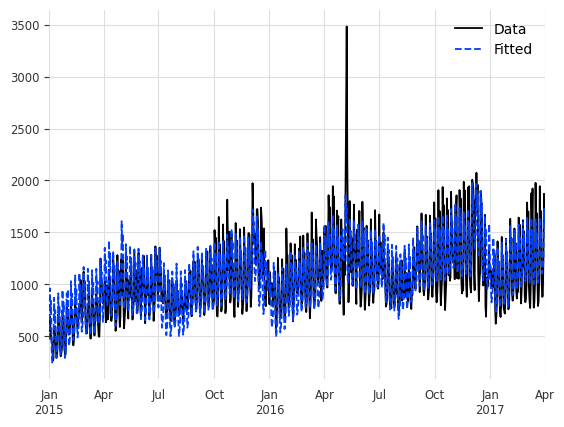

In [269]:
train['sold'].plot(label='Data')
pred.plot(label='Fitted', linestyle='--')
plt.legend()

<Figure size 5000x600 with 0 Axes>

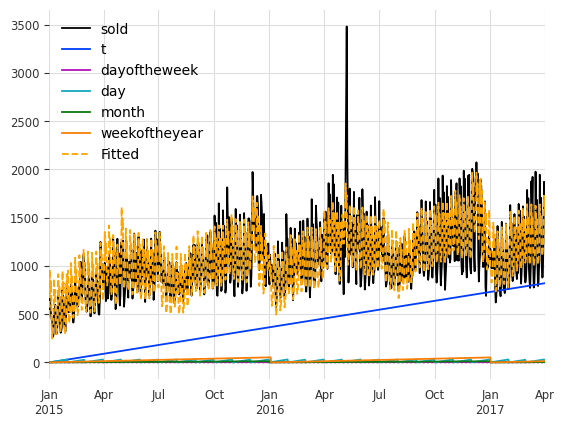

In [271]:
import matplotlib.pyplot as plt

# Set a wider figure size
plt.figure(figsize=(50, 6))  # You can adjust the width (12) and height (6) as needed

# Plot the actual data
train.plot(label='Data')

# Plot the fitted values with custom style
pred.plot(label='Fitted', linestyle='--', c='orange')

# Add labels and legend
plt.legend()

# Show the plot
plt.show()


In [273]:
train.t

2015-01-01      0
2015-01-02      1
2015-01-03      2
2015-01-04      3
2015-01-05      4
             ... 
2017-03-29    818
2017-03-30    819
2017-03-31    820
2017-04-01    821
2017-04-02    822
Freq: D, Name: t, Length: 823, dtype: int64

How does it look like?

Compute both MAPE and sMAPE.

In [275]:
# compute MAPE and sMAPE
mape(train['sold'], mod_dummy.predict(train)), smape(train['sold'], mod_dummy.predict(train))

(12.741527740778501, 12.40149973111423)

Now, make a forecast for the next 28 days. We'll need to recreate the index for the test set as well to re-create the same features we chose to extract in the training set.

In [277]:
index = pd.date_range('2017-04-03', periods=28, freq='D')
test.index = index

test['t'] = pd.RangeIndex(len(test)) + 823

# create one or more columns in the DF using properties of the index - they must match those of the training set
test['dayoftheweek'] = test.index.dayofweek
test['day'] = test.index.day
test['month'] = test.index.month
test['weekoftheyear'] = test.index.isocalendar().week.astype(int)
test.drop(columns=['sold'])

,t,dayoftheweek,day,month,weekoftheyear
2017-04-03,823,0,3,4,14
2017-04-04,824,1,4,4,14
2017-04-05,825,2,5,4,14
2017-04-06,826,3,6,4,14
2017-04-07,827,4,7,4,14
2017-04-08,828,5,8,4,14
2017-04-09,829,6,9,4,14
2017-04-10,830,0,10,4,15
2017-04-11,831,1,11,4,15
2017-04-12,832,2,12,4,15


Use the model to make the forecast:

In [279]:
# create a list of the column names you used in the formula
columns = ['dayoftheweek', 't', 'month', 'weekoftheyear']

features = test[columns]

fcast =  mod_dummy.predict(test[columns])
#test['sold'] = fcast
test

,sold,t,dayoftheweek,day,month,weekoftheyear
2017-04-03,964,823,0,3,4,14
2017-04-04,874,824,1,4,4,14
2017-04-05,924,825,2,5,4,14
2017-04-06,1149,826,3,6,4,14
2017-04-07,1933,827,4,7,4,14
2017-04-08,1752,828,5,8,4,14
2017-04-09,1634,829,6,9,4,14
2017-04-10,1246,830,0,10,4,15
2017-04-11,1094,831,1,11,4,15
2017-04-12,1318,832,2,12,4,15


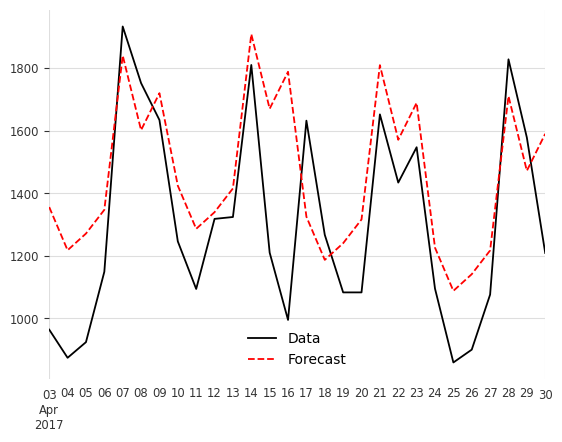

In [281]:
test['sold'].plot(label='Data')
fcast.plot(label='Forecast', linestyle='--', c='r')
plt.legend()

In [195]:
fcast

2017-04-03     652.368377
2017-04-04     738.995347
2017-04-05     825.622318
2017-04-06     912.249288
2017-04-07     998.876258
2017-04-08    1085.503228
2017-04-09    1172.130199
2017-04-10     654.986133
2017-04-11     741.613103
2017-04-12     828.240073
2017-04-13     914.867044
2017-04-14    1001.494014
2017-04-15    1088.120984
2017-04-16    1174.747954
2017-04-17     657.603888
2017-04-18     744.230859
2017-04-19     830.857829
2017-04-20     917.484799
2017-04-21    1004.111769
2017-04-22    1090.738740
2017-04-23    1177.365710
2017-04-24     660.221644
2017-04-25     746.848614
2017-04-26     833.475585
2017-04-27     920.102555
2017-04-28    1006.729525
2017-04-29    1093.356495
2017-04-30    1179.983466
dtype: float64

What does this forecast look like? Is it good or not? Why?

### Lags

Now, let's use DARTS to create a linear model that uses lags of the target variable itself as features. Although it's a simple linear regression, using DARTS saves us the trouble of having to loop through predictions to make forecast several periods ahead.

The `lags` argument takes a list of negative values corresponding to how many time steps in the past should be used as features. For example, `-1` indicates the value from yesterday (assuming daily frequency) should be used as feature to forecast today's value.

Create a model and choose one or more lags (consider the seasonality of the time series in your choice). DARTS requires the input to be a `TimeSeries` object, so we're creating one from a copy of our series.

In [217]:
from darts import TimeSeries
new_y = train['sold'].copy()
ts_y = TimeSeries.from_series(new_y)
ts_y

<TimeSeries (DataArray) (time: 823, component: 1, sample: 1)>
array([[[ 554.]],

       [[ 695.]],

       [[ 585.]],

       [[ 491.]],

       [[ 449.]],

       [[ 429.]],

       [[ 266.]],

       [[ 286.]],

       [[ 557.]],

       [[ 482.]],

...

       [[1945.]],

       [[1478.]],

       [[1706.]],

       [[1054.]],

       [[ 880.]],

       [[ 888.]],

       [[1246.]],

       [[1872.]],

       [[1659.]],

       [[1860.]]])
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2017-04-02
  * component  (component) object 'sold'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [302]:
from darts.models import LinearRegressionModel

# create a list of the lags to be used as features
lags = [-1, -7, -28]

model = LinearRegressionModel(lags=lags)
# fit the model
model.fit(ts_y)
ts_y

<TimeSeries (DataArray) (time: 814, component: 1, sample: 1)>
array([[[ 482.]],

       [[ 597.]],

       [[ 384.]],

       [[ 293.]],

       [[ 315.]],

       [[ 455.]],

       [[ 712.]],

       [[ 660.]],

       [[ 681.]],

       [[ 370.]],

...

       [[1945.]],

       [[1478.]],

       [[1706.]],

       [[1054.]],

       [[ 880.]],

       [[ 888.]],

       [[1246.]],

       [[1872.]],

       [[1659.]],

       [[1860.]]])
Coordinates:
  * time       (time) datetime64[ns] 2015-01-10 2015-01-11 ... 2017-04-02
  * component  (component) object 'sold'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

You can inspect the corresponding coefficients by retrieving the underlying linear model (which is a Scikit-Learn model in this case):

In [286]:
model.model

LinearRegression()

In [288]:
model.model.coef_

array([0.21590765, 0.50811535, 0.23878634])

Use the model's `historical_forecasts()` method to obtain the fitted values:

In [291]:
fittedvals = model.historical_forecasts(ts_y,enable_optimization=False)

793
814


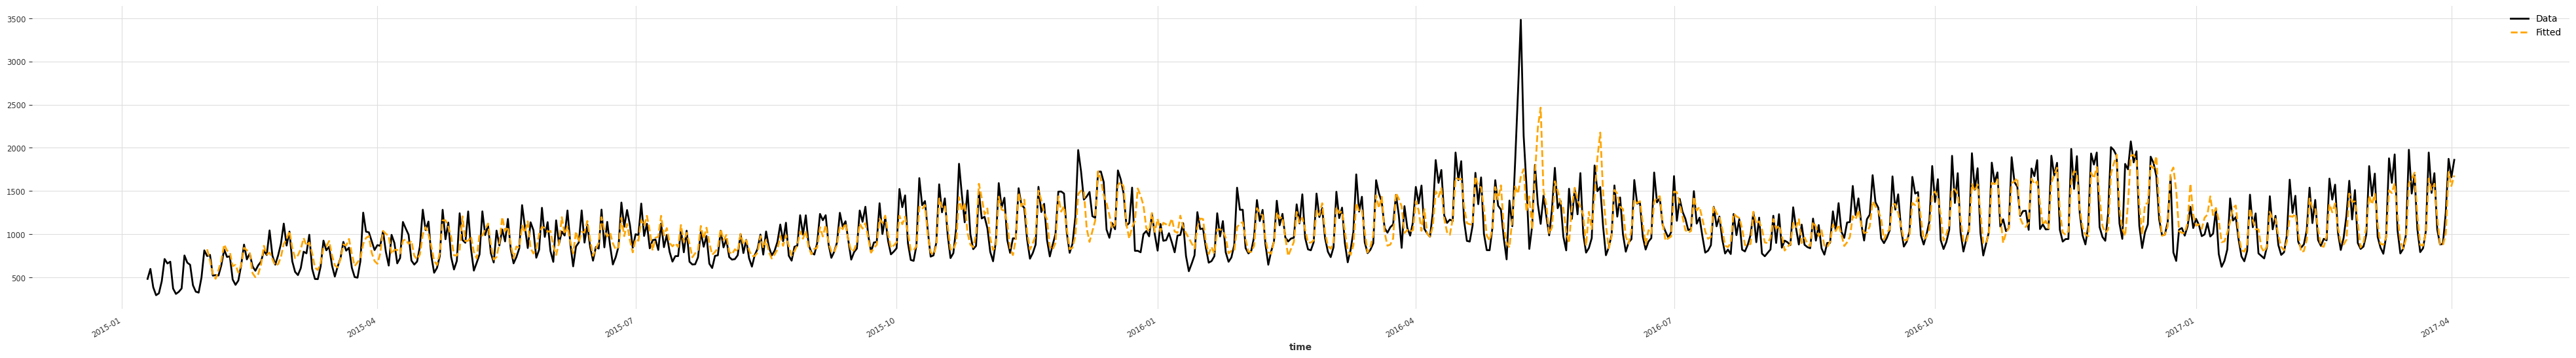

793
814


In [297]:
import matplotlib.pyplot as plt

# Set a wider figure size
plt.figure(figsize=(50, 6))  # You can adjust the width (12) and height (6) as needed

# Plot the actual data
ts_y.plot(label='Data')

# Plot the fitted values with custom style
fittedvals.plot(label='Fitted', linestyle='--', c='orange')

print(len(fittedvals))
print(len(ts_y))
# Add labels and legend
plt.legend()

# Show the plot
plt.show()
#ts_y = ts_y[9:]
print(len(fittedvals))
print(len(ts_y))

Let's check both MAPE and sMAPE (since we're using lagged features, there are fewer fitted values than the number of original values):

In [300]:
mape(ts_y.values()[30:], fittedvals.values()), smape(ts_y.values()[30:], fittedvals.values())

AssertionError: Length of actual and forecast arrays should be the same

Now, use the model's `predict()` method to make a forecast for 28 days in the future.

In [219]:
fcast = model.predict(28)
fcast

<TimeSeries (DataArray) (time: 28, component: 1, sample: 1)>
array([[[1272.16937336]],

       [[1003.21453693]],

       [[ 937.79830694]],

       [[1156.14023756]],

       [[1625.37262011]],

       [[1608.54827222]],

       [[1736.36747297]],

       [[1383.21605318]],

       [[1113.46131688]],

       [[ 999.5333813 ]],

...

       [[1334.59655112]],

       [[1447.1005157 ]],

       [[1545.46289341]],

       [[1436.52983096]],

       [[1255.71989871]],

       [[1118.89790473]],

       [[1108.69243524]],

       [[1259.33890191]],

       [[1372.9456158 ]],

       [[1467.51459524]]])
Coordinates:
  * time       (time) datetime64[ns] 2017-04-03 2017-04-04 ... 2017-04-30
  * component  (component) object 'sold'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='time'>

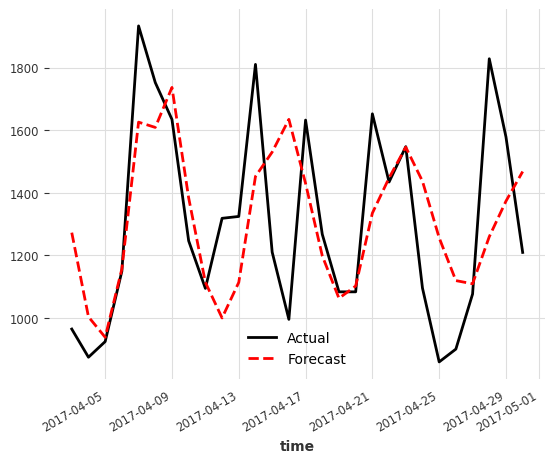

In [221]:
TimeSeries.from_series(test['sold']).plot(label='Actual')
fcast.plot(label='Forecast', c='r', linestyle='--')

Is this forecast better or worse than that produced by the model using date components? How is it different?

## ML Model

Now, let's use a ML model to combine both lagged features, date components, and yet another feature: holidays.

### Holidays

Holidays are important features whenever human behavior is part of the data generating process (e.g. sales, travel, etc.). In DARTS, we can retrieve holidays for countries and regions using the `holidays_timeseries()` function.

In [ ]:
from darts.utils.timeseries_generation import holidays_timeseries

def get_holiday(idx):
    return holidays_timeseries(idx, country_code='DE')

Holidays, like other date components, are known **ahead of time**, so they are **future covariates**. To build the corresponding time series, so that we can use it in our ML model, we need to compute holiday features for the totality of dates (both in train and test sets).

In [ ]:
future_cov = get_holiday(train.index.union(test.index))
future_cov

Use DARTS `datetime_attribute_timeseries` to create more future covariates, such as month, day of the week, and week of the year. The time series object has a `stack()` method so you can stack them up on the `future_cov` variable used to retrieve the holidays.

In [ ]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

time_index = train.index.union(test.index)

# create your covariates here
...

future_cov = ...
future_cov = future_cov.astype(np.float32)
future_cov

Now, create an instance of `RandomForest` model. You may provide the following arguments:
- `lags`: a list of **negative** values specifying the lags to be used as features
- `lags_future_covariates`: a list of **positive** values specifying the look-ahead for the future covariates, a value of 0 means it will use the value for the date being forecast
- `output_chunk_length`: how many steps ahead you'd like the model to predict (e.g. 1 for single-step or 7 for predicting 7 days ahead at once thus avoiding auto-regressing behavior inside this time period)

You also need to provide arguments that are specific to the chosen model (random forest), such as `n_estimators` (the number of trees), `max_depth`, and `criterion` (e.g. `absolute error`).

In [ ]:
from darts.models import RandomForest

# create an instance of the RandomForest model
model2 = ...

Once the model is created, you may call its `fit()` method as usual, but don't forget to pass your future covariates (holidays, in this case) in the `future_covariates` argument:

In [ ]:
# fit the model (don't forget the future covariates)
...

Use the model's `historical_forecasts()` method to obtain the fitted values. We may set the `retrain` argument to false to avoid retraining as many models as there are data points.

In [ ]:
fittedvals = ...

In [ ]:
ts_y.plot(label='Data')
fittedvals.plot(label='Fitted', linestyle='--', c='orange')

Let's check both MAPE and sMAPE (since we're using lagged features, there are fewer fitted values than the number of original values):

In [ ]:
mape(ts_y.values()[28:], fittedvals.values()), smape(ts_y.values()[28:], fittedvals.values())

We may also retrieve the feature importances since it's a tree-based model:

In [ ]:
model2.lagged_feature_names

In [ ]:
dict(zip(model2.lagged_feature_names, model2.model.feature_importances_))

Check the most important features. Do they make sense, intuitively speaking?

Now, use the model's `predict()` method to make a forecast for 28 days in the future.

In [ ]:
pred2 = ...

In [ ]:
TimeSeries.from_series(test['sold']).plot(label='Actual')
pred2.plot(label='Forecast', c='r', linestyle='--')

# Part #4

### Backtesting

We can also backtest, that is, cross-validate on a variety of rolling windows, with or without retraining using DARTS' `backtest()` method.

It requires the time series and future covariates, just like the `fit()` method, but it also requires a few other arguments that drive the splitting behavior (`start`, `forecast_horizon`, `stride`, `train_length`) and, if you'd like to inspect the metrics after every step, the `reduction` argument should be set to `None`.

We may retrain the model every week (`stride=7`) to make predictions for the following week or month (`forecast_horizon` equals 7 or 28), using 750 data points (`train_length`) to begin with.

In [ ]:
res7 = model2.backtest(ts_y, future_covariates=future_cov,
                       start=None, forecast_horizon=7, stride=7, train_length=750, reduction=None)
res28 = model2.backtest(ts_y, future_covariates=future_cov,
                        start=None, forecast_horizon=28, stride=7, train_length=750, reduction=None)

In [ ]:
print(res7)

In [ ]:
print(res28)

# BONUS

### TBATS

In [ ]:
from tbats import TBATS

if __name__ == '__main__':
    estimator = TBATS(seasonal_periods=[7, 365.25], n_jobs=1)

In [ ]:
# Fit model
fitted_model = estimator.fit(train['sold'])

# Summarize fitted model
print(fitted_model.summary())

In [ ]:
ax = train['sold'].plot(label='Data')
pred = pd.Series(fitted_model.y_hat, index=train['sold'].index)
ax.plot(pred, label='Fitted', linestyle='--')
plt.legend()

In [ ]:
mape(train['sold'], pred), smape(train['sold'], pred)

In [ ]:
# Forecast 28 steps ahead
fcast = fitted_model.forecast(steps=28)
fcast

In [ ]:
ax = test['sold'].plot(label='Data')
ax.plot(pd.Series(fcast, index=test['sold'].index), label='Forecast', linestyle='--', c='r')
plt.legend()